<a href="https://colab.research.google.com/github/MilanHassan/Image_Classification_Flowers/blob/main/Copy_of_Image_Classification_Final_Version_Testing_Accuracy_%3E_90_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import neccesary libraries**

In [ ]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import pandas as pd
import random
import cv2
from PIL import Image
import tensorflow 

from numpy.random import seed
seed(1337)
tensorflow.random.set_seed(42)

from keras.applications import vgg16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.callbacks import ModelCheckpoint
from keras import layers, models, Model, optimizers

from keras.preprocessing.image import img_to_array
from keras.utils import to_categorical

**Storing the path of the data into variables**

In [ ]:
train_data_dir = "/content/data/train"
val_data_dir = "/content/data/val"
test_data_dir = "/content/data/test"

**Transfer Learning using VGG16**

In [ ]:
img_height, img_width = 224,224
conv_base = vgg16.VGG16(weights='imagenet', include_top=False, pooling='max', input_shape = (img_width, img_height, 3))

**VGG16 Architecture**

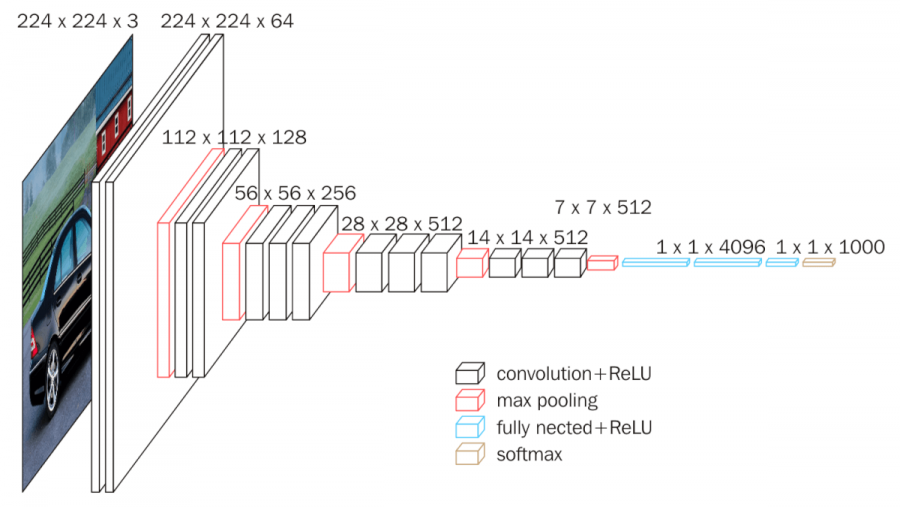

In [ ]:
from IPython.core.display import Image, display
display(Image('https://neurohive.io/wp-content/uploads/2018/11/vgg16-1-e1542731207177.png', width=700, unconfined=True))

In [ ]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

**Data Preprocessing - Resizing + Data augmentation**

In [ ]:
batch_size = 32

train_datagen = ImageDataGenerator(
        rescale=1./255,
        rotation_range=10,
        zoom_range=0.2,
        width_shift_range=0.3,
        height_shift_range=0.4,
        horizontal_flip=True,
        brightness_range = (0.9,1.1),
        fill_mode='nearest')
        
        
       

test_datagen =  ImageDataGenerator(rescale=1./255)

val_datagen = ImageDataGenerator(rescale = 1./255)



**Data Preprocessing**

In [ ]:
print('Total number of images for "training":')

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size, 
    class_mode = "categorical")

print('Total number of images for "validation":')

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=False)

print('Total number of images for "testing":')

test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size = (img_height, img_width),
    batch_size = batch_size,
    class_mode = "categorical",
    shuffle=True)

Total number of images for "training":
Found 3022 images belonging to 5 classes.
Total number of images for "validation":
Found 647 images belonging to 5 classes.
Total number of images for "testing":
Found 654 images belonging to 5 classes.


**Plotting different classes**

Text(0.5, 1.0, 'Number of training images per category:')

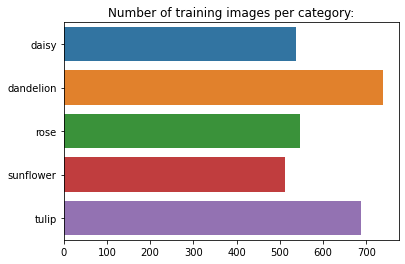

In [ ]:
category_names = sorted(os.listdir('/content/data1/train'))
nb_categories = len(category_names)
img_pr_cat = []
for category in category_names:
    folder = 'data1/train' + '/' + category
    img_pr_cat.append(len(os.listdir(folder)))
sns.barplot(y=category_names, x=img_pr_cat).set_title("Number of training images per category:")

**Plotting train images with their labels**

In [ ]:
def plots(ims, figsize=(16,16), rows=4, interp=False, titles=None):
  f = plt.figure(figsize=figsize)
  cols = len(ims)//rows if len(ims) & 2 ==0 else len(ims)//rows + 1
  for i in range(len(ims)):
    sp = f.add_subplot(rows, cols, i+1)
    sp.axis('off')
    sp.set_title(class_names[titles[i].tolist().index(1)], fontsize=16)
    plt.imshow(ims[i])

In [ ]:
class_names = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'] #Creating a dictionary of class names according to label

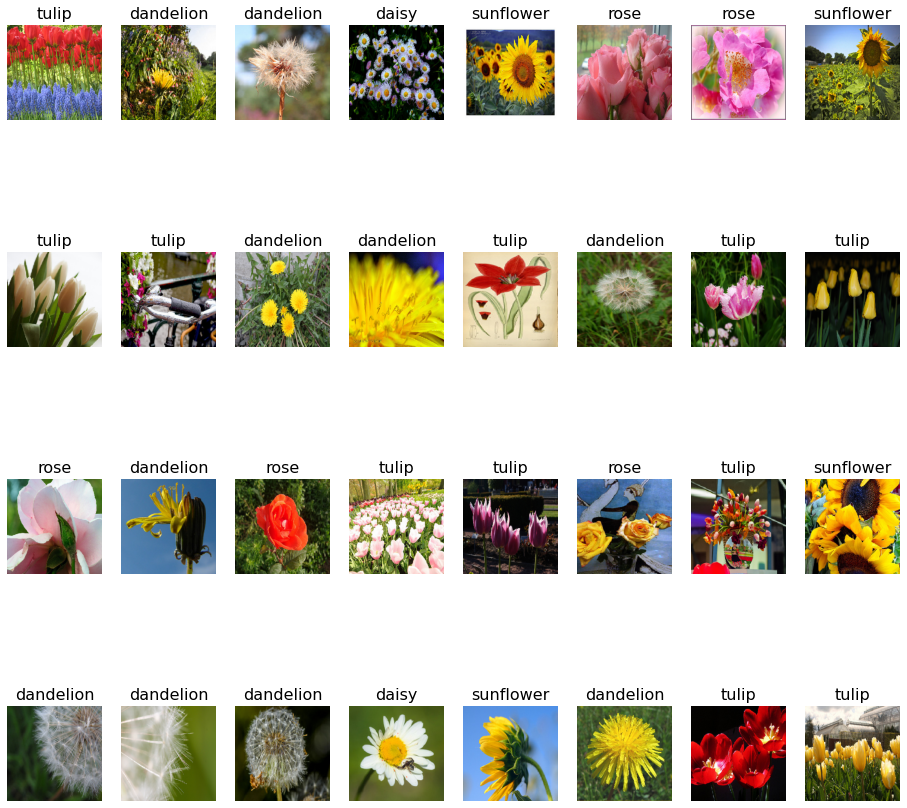

In [ ]:
imgs, labels = next(train_generator)
plots(imgs, titles=labels)

**Model Creation - Replacing Last Dense Layer with our own**

In [ ]:
#for layer in conv_base.layers[:-13]:
 #  layer.trainable = False

In [ ]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Dense(nb_categories, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


**Plotting a graphical representation of the model**

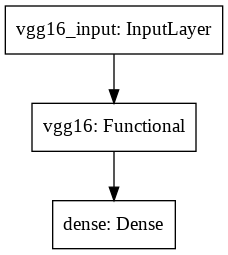

In [ ]:
import keras
import pydotplus

from keras.utils.vis_utils import model_to_dot

keras.utils.plot_model(model)

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 512)               14714688  
_________________________________________________________________
dense (Dense)                (None, 5)                 2565      
Total params: 14,717,253
Trainable params: 14,717,253
Non-trainable params: 0
_________________________________________________________________


**Compiling and Training**

In [ ]:
learning_rate = 5e-5
epochs = 10
checkpoint = ModelCheckpoint("sign_classifier.h5", monitor = 'val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', period=1)
model.compile(loss="categorical_crossentropy", optimizer=optimizers.Adam(lr=learning_rate, clipnorm = 1.), metrics = ['acc'])

In [ ]:
history = model.fit_generator(train_generator, 
                              epochs=epochs, 
                              shuffle=True, 
                              validation_data=val_generator,
                              callbacks=[checkpoint] )

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
95/95 [==============================] - 53s 494ms/step - loss: 1.0412 - acc: 0.5959 - val_loss: 0.4433 - val_acc: 0.8207

Epoch 00001: val_acc improved from -inf to 0.82071, saving model to sign_classifier.h5
Epoch 2/10
95/95 [==============================] - 43s 453ms/step - loss: 0.3391 - acc: 0.8769 - val_loss: 0.4676 - val_acc: 0.8253

Epoch 00002: val_acc improved from 0.82071 to 0.82535, saving model to sign_classifier.h5
Epoch 3/10
95/95 [==============================] - 43s 457ms/step - loss: 0.2201 - acc: 0.9242 - val_loss: 0.3202 - val_acc: 0.8887

Epoch 00003: val_acc improved from 0.82535 to 0.88872, saving model to sign_classifier.h5
Epoch 4/10
95/95 [==============================] - 43s 453ms/step - loss: 0.1149 - acc: 0.9554 - val_loss: 0.3908 - val_acc: 0.8872

Epoch 00004: val_acc did not improve from 0.88872
Epoch 5/10
95/95 [==============================] - 44s 458ms/step - loss: 0.0854 - acc: 0.9728 - val_loss: 0.4976 - val_acc: 0.8841

Epoch 00005: 

**Visualize training results**

In [ ]:
model = models.load_model("sign_classifier.h5")

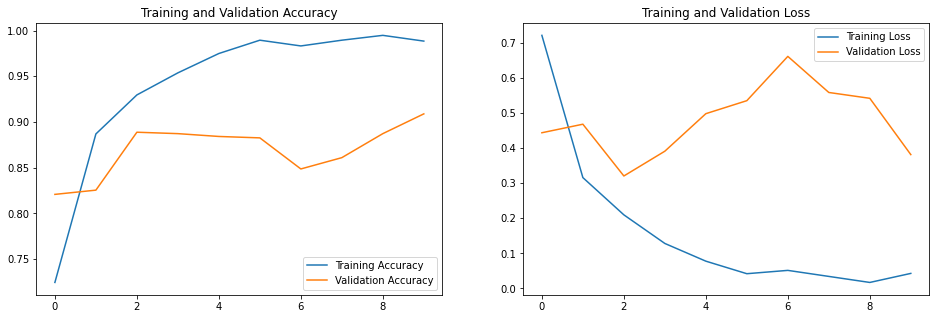

In [ ]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(16, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

**Predict on test data**

In [ ]:
model.save('sign_classifier.h5')

In [ ]:
model.evaluate_generator(test_generator, steps=20)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


[0.3329596221446991, 0.903124988079071]

**Prediction on test data visualised**

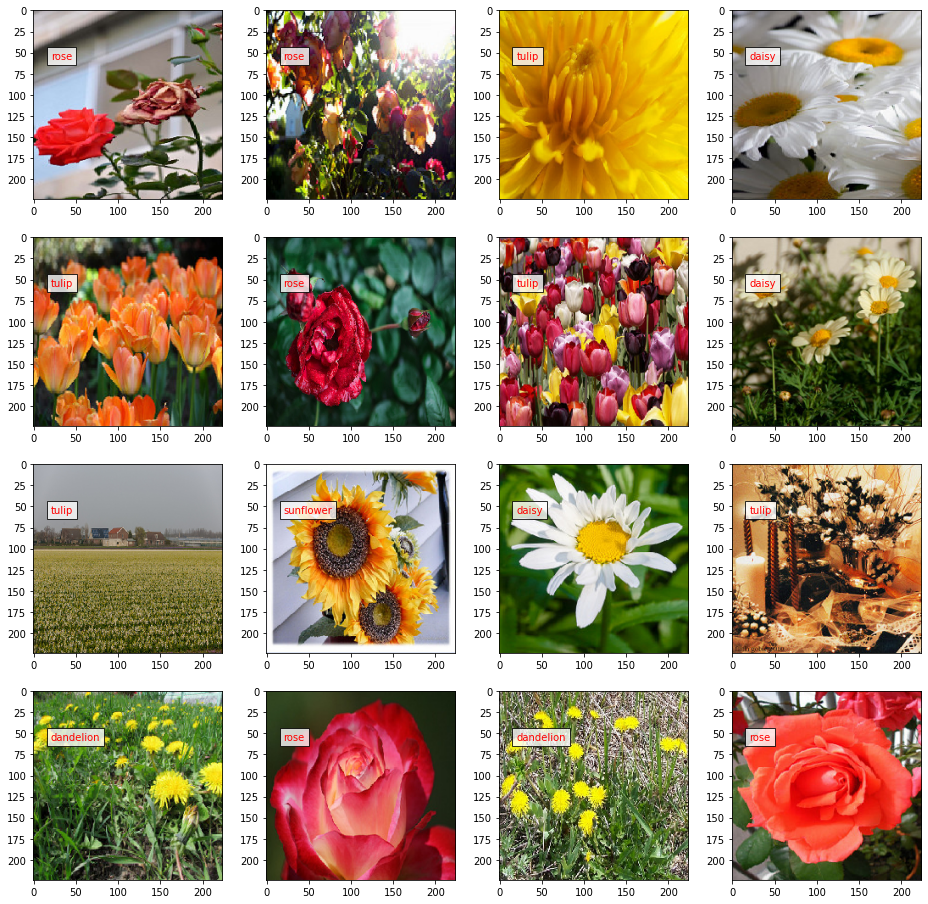

In [ ]:
imgs, labels = next(test_generator)
fig=plt.figure(figsize=(16,16))
columns = 4
rows = 4
for i in range(columns*rows):
  fig.add_subplot(rows, columns, i+1)
  img_t= np.expand_dims(imgs[i], axis=0)
  prediction = model.predict(img_t)
  idx = prediction[0].tolist().index(max(prediction[0]))
  plt.text(20, 58, class_names[idx], color= 'red', fontsize=10, bbox=dict(facecolor='white', alpha=0.8))
  plt.imshow(imgs[i])